In [69]:
import json
import os.path as osp
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict

In [161]:
base_path = "."
train_data = json.load(open(osp.join("train.story-in-sequence.json")))
val_data = json.load(open(osp.join("val.story-in-sequence.json")))
test_data = json.load(open(osp.join("test.story-in-sequence.json")))


In [176]:
prefix = ["train", "val", "test"]

In [180]:
test_path = '/root/xhong/VStorytelling/Coherent_VStorytelling/kemhra/vist/data/plan/test0_src.txt'
train_path = '/root/xhong/VStorytelling/Coherent_VStorytelling/kemhra/vist/data/plan/train_src.txt'
val_path = '/root/xhong/VStorytelling/Coherent_VStorytelling/kemhra/vist/data/plan/val0_src.txt'

In [181]:
src_dict = {}

In [194]:
for p in prefix:
    src_path = eval(p + '_path')
    with open(src_path, 'r') as f:
        src_dict[p] = f.readlines()

In [195]:
def get_dict(line_list):
    story_dict = defaultdict(list)
    for line in line_list:
        tokens = line.split()
        story_id = tokens[0]
        sentences = line.split('<S>')
        sentences[0] = sentences[0].replace(story_id + ' ', '')
        if len(sentences) != 5:
            continue
        # print ('len(sentences)', len(sentences))
        for sent in sentences:
            story_dict[story_id].append(sent)
    return story_dict

In [196]:
# for i in range(10):
#     print test_data["annotations"][i][0]
#     print ''

In [197]:
story_plan_dict = {}
for p in prefix:
    story_plan_dict[p] = get_dict(src_dict[p])


In [198]:
for p in prefix:
    print len(story_plan_dict[p])

36532
4515
4591


In [199]:
valid_dict['40470']

['<V> arrived <A1> My sister <V> help <A0> My sister <A1> with the family Bar BQ <A2> me ',
 '  <V> arrived <A1> Every one else ',
 '  <V> manned <A0> Dad <A1> the grill ',
 '  <V> was <A1> so much food <V> was <A1> it <A2> delicious ',
 '  \n']

In [201]:
whole_album2im = {}
for i, data in enumerate([train_data, val_data, test_data]):
    album2im = {}
    for im in data['images']:
        if im['album_id'] not in album2im:
            album2im[im['album_id']] = [im['id']]
        else:
            if im['id'] not in album2im[im['album_id']]:
                album2im[im['album_id']].append(im['id'])
    whole_album2im[prefix[i]] = album2im

whole_album = {}
story_lines = {}
whole_lines = {}
story_line_count = 0
whole_line_count = 0
for i, data in enumerate([train_data, val_data, test_data]):
    p = prefix[i]
    story_plans = story_plan_dict[p]
    album_mapping = {}
    for annot_new in data["annotations"]:
        annot = annot_new[0]
        assert len(annot_new) == 1
        
        story_id = annot['story_id']
        photo_order = annot['worker_arranged_photo_order']
        
        story_plan = story_plans[story_id]
        if len(story_plan) != 5:
            continue
            
        sentence_plan = story_plan[int(photo_order)]
        
        # change the text here!
        text = sentence_plan
        
        if annot['story_id'] not in album_mapping:
            album_mapping[annot['story_id']] = {"text_index": [story_line_count], "flickr_id": [annot['photo_flickr_id']], "length": 1, 
                                                "album_id": annot['album_id'], "album_flickr_id": whole_album2im[prefix[i]][annot['album_id']],
                                                "whole_text_index": whole_line_count, "origin_text": text}
            story_lines[annot['story_id']] = [{"index": story_line_count, "text": text.split()}]
            whole_lines[annot['story_id']] = {"index": whole_line_count, "text": text.split()}
            whole_line_count +=1
        else:
            album_mapping[annot['story_id']]["text_index"].append(story_line_count)
            album_mapping[annot['story_id']]["flickr_id"].append(annot['photo_flickr_id'])
            album_mapping[annot['story_id']]["length"] += 1
            story_lines[annot['story_id']].append({"index": story_line_count, "text": text.split()})
            whole_lines[annot['story_id']]["text"].extend(text.split())
            album_mapping[annot['story_id']]["origin_text"] += " " + text 
        story_line_count += 1
    whole_album[prefix[i]] = album_mapping

new_story_lines = [] 
for l in story_lines.values():
    for li in l:
        new_story_lines.append(li)
story_lines = new_story_lines
whole_lines = whole_lines.values()

story_lines = [r['text'] for r in sorted(story_lines, key=lambda thing: thing['index'])]
whole_lines = [r['text'] for r in sorted(whole_lines, key=lambda thing: thing['index'])]

print len(story_lines)
print len(whole_lines)

from collections import Counter
import numpy
cnt = Counter()
for l in story_lines:
    words = l
    for w in words:
        cnt[w] += 1
words2id = {}
idx = 2
for k, v in cnt.most_common():
    if v > 5:
        words2id[k] = idx
        idx += 1
words2id["<EOS>"] = 0
words2id["<UNK>"] = 1
id2words = {v:k for k,v in words2id.iteritems()}
print len(id2words)

whole_album["words2id"] = words2id
whole_album["id2words"] = {v:k for k,v in words2id.iteritems()}

id_story_lines = []
for l in story_lines:
    s = [words2id[w] if w in words2id else 1 for w in l]
    id_story_lines.append(s)

id_whole_lines = []
for l in whole_lines:
    s = [words2id[w] if w in words2id else 1 for w in l]
    id_whole_lines.append(s)

new_id_whole_lines = []
specify_longest = 105
for i in range(len(id_whole_lines)):
    cur_len = len(id_whole_lines[i])
    if cur_len < specify_longest:
        new_id_whole_lines.append(id_whole_lines[i] + [0] * (specify_longest - cur_len))
    else:
        new_id_whole_lines.append(id_whole_lines[i][:specify_longest-1] + [0])

data = numpy.asarray(new_id_whole_lines)
import h5py
f = h5py.File("full_story.h5", "w")
f.create_dataset("story", data=data)
f.close()

new_id_story_lines = []
specify_longest = 30
for i in range(len(id_story_lines)):
    cur_len = len(id_story_lines[i])
    if cur_len < specify_longest:
        new_id_story_lines.append(id_story_lines[i] + [0] * (specify_longest - cur_len))
    else:
        new_id_story_lines.append(id_story_lines[i][:specify_longest-1] + [0])

data = numpy.asarray(new_id_story_lines, "int32")
import h5py
f = h5py.File("story.h5", "w")
f.create_dataset("story", data=data)
f.close()

228190
45638
9362


In [202]:
for p in prefix:
    path = "/root/xhong/VStorytelling/AREL/database/resnet_features/fc/{}/".format(p)
    deletables = []
    for story_id, story in whole_album[p].iteritems():
        d = [osp.exists(osp.join(path, "{}.npy".format(_))) for _ in story["flickr_id"]]
        if sum(d) < 5:
            print "deleting {}".format(story_id)
            deletables.append(story_id)
        else:
            pass
    for i in deletables:
        del whole_album[p][i]

deleting 38600
deleting 38602
deleting 38603
deleting 8085
deleting 8080
deleting 8081
deleting 8082
deleting 8083
deleting 8089
deleting 7462
deleting 7464
deleting 36709
deleting 36708
deleting 36707
deleting 36706
deleting 36705
deleting 18994
deleting 18992
deleting 18993
deleting 18990
deleting 18991
deleting 36659
deleting 36658
deleting 36655
deleting 36656
deleting 8053
deleting 8052
deleting 8051
deleting 8050
deleting 8054
deleting 36756
deleting 36757
deleting 8020
deleting 8024
deleting 24331
deleting 24333
deleting 24332
deleting 24334
deleting 18610
deleting 25587
deleting 25586
deleting 25588
deleting 33059
deleting 33055
deleting 33056
deleting 33057
deleting 7388
deleting 7389
deleting 7387
deleting 7385
deleting 41915
deleting 41919
deleting 49044
deleting 49043
deleting 49040
deleting 49041


In [203]:
flickr_story_map = {}
for pre in prefix:
    album = whole_album[pre]
    for k, v in album.iteritems():
        indexes = v['text_index']
        for i, flickr_id in enumerate(v['flickr_id']):
            if flickr_id not in flickr_story_map:
                flickr_story_map[flickr_id] = [indexes[i]]
            else:
                flickr_story_map[flickr_id].append(indexes[i])

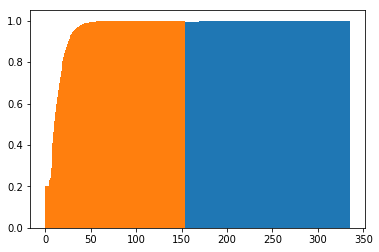

In [206]:
length_distribution = [len(s) for s in whole_lines]
result = plt.hist(length_distribution, bins='auto', cumulative=True, normed=1)
#plt.show()
length_distribution = [len(s) for s in story_lines]
result = plt.hist(length_distribution, bins='auto', cumulative=True, normed=1)
#plt.hist(length_distribution, bins='auto')
#plt.show()

In [207]:
import json
import os.path as osp

base_dii_path = "/root/xhong/VStorytelling/SIND/data/dii"
train_dii_data = json.load(open(osp.join(base_path, "train.description-in-isolation.json")))
val_dii_data = json.load(open(osp.join(base_path, "val.description-in-isolation.json")))
test_dii_data = json.load(open(osp.join(base_path, "test.description-in-isolation.json")))


In [208]:
mapping = {}
mapping_original = {}
text_list = []
text_list_count = 0
unknown_words = 0
total_words = 0
with_story = 0
no_story = 0
for i, data in enumerate([train_dii_data, val_dii_data, test_dii_data]):
    mapping[prefix[i]] = {}
    mapping_original[prefix[i]] = {}
    for l in data['annotations']:
        if l[0]['photo_flickr_id'] not in mapping[prefix[i]]:
            if l[0]['photo_flickr_id'] in flickr_story_map:
                stories =  flickr_story_map[l[0]['photo_flickr_id']]
            else:
                stories = [-1]
            mapping[prefix[i]][l[0]['photo_flickr_id']] = {'caption': [text_list_count], 'story': stories}
            mapping_original[prefix[i]][l[0]['photo_flickr_id']] = [l[0]['text']]
        else:
            mapping[prefix[i]][l[0]['photo_flickr_id']]['caption'].append(text_list_count)
            mapping_original[prefix[i]][l[0]['photo_flickr_id']].append(l[0]['text'])
        text_list_count += 1
        assert len(l) == 1
        s = []
        for w in l[0]['text'].split(" "):
            if w in words2id:
                s.append(words2id[w])  
            else:
                s.append(1)
                unknown_words += 1
            total_words += 1
        text_list.append(s)
print "unknown words percent is {}".format(unknown_words / (total_words + 0.0))
new_text_list = []
specify_longest = 20
for i in range(len(text_list)):
    cur_len = len(text_list[i])
    if cur_len < specify_longest:
        new_text_list.append(text_list[i] + [0] * (specify_longest - cur_len))
    else:
        new_text_list.append(text_list[i][:specify_longest - 1] + [0]) 

for p in prefix:
    path = "/root/xhong/VStorytelling/AREL/database/resnet_features/fc/{}/".format(p)
    deletables = []
    for flickr_id, story in mapping[p].iteritems():
        if not osp.exists(osp.join(path, "{}.npy".format(flickr_id))):
            deletables.append(flickr_id)
    for i in deletables:
        del mapping[p][i]
        del mapping_original[p][i]
        
whole_album["image2caption"] = mapping
whole_album["image2caption_original"] = mapping_original

with open("story_line.json", 'w') as f:
    json.dump(whole_album, f)

text_array = numpy.asarray(new_text_list, dtype='int32')
import h5py
f = h5py.File("description.h5", 'w')
f.create_dataset("story", data=text_array)
f.close()

unknown words percent is 0.0339461862123


In [209]:
import json
import os.path as osp

# val_data = json.load(open(osp.join(base_path, "val.description-in-isolation.json")))

with open("val_desc_reference", "w") as f:
    for l in val_data['annotations']:
        print >> f, "{}\t{}".format(l[0]['photo_flickr_id'], l[0]['text'])

import h5py
f = h5py.File("full_story.h5", "r")
print f['story'][0]

f = h5py.File("story.h5", "r")
print f['story'].shape

f = open("story_line.json", 'r')
data = json.load(f)
print len(data['id2words'])

[   2  119    4   84    3   43  340    2   15    2  177    4  108    2
 1052    3   45   16    9  759 1763  165    2   16    3   45    6    9
  759 1763    2   16    3   14  340    6   41 1412    2 5048    3 3991
 4160    2   11    3   14 3693    6  117 1492   42   82  128   82 3761
  887    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
(228190, 30)
9362


In [210]:
# import os
# import numpy

# zero_fc = numpy.zeros((2048, ), "float32")
# zero_conv = numpy.zeros((2048, 7, 7), "float32")

# train_fc_base = "/mnt/sshd/xwang/VIST/feature/train/fc"
# train_conv_base = "/mnt/sshd/xwang/VIST/feature/train/conv"
# train_name1 = [l.split(".")[0] for l in os.listdir(train_fc_base)]

# train_image_base = "/mnt/sshd/wenhuchen/VIST/images/train"
# train_name2 = [l.split(".")[0] for l in os.listdir(train_image_base)]

# rest = set(train_name2) - set(train_name1)
# for image in rest:
#     numpy.save(os.path.join(train_fc_base, "{}.npy".format(image)), zero_fc) 
#     numpy.save(os.path.join(train_conv_base, "{}.npy".format(image)), zero_conv) 

# val_fc_base = "/mnt/sshd/xwang/VIST/feature/val/fc"
# val_conv_base = "/mnt/sshd/xwang/VIST/feature/val/conv"
# val_name1 = [l.split(".")[0] for l in os.listdir(val_fc_base)]

# val_image_base = "/mnt/sshd/wenhuchen/VIST/images/val"
# val_name2 = [l.split(".")[0] for l in os.listdir(val_image_base)]

# rest = set(val_name2) - set(val_name1)
# for image in rest:
#     numpy.save(os.path.join(val_fc_base, "{}.npy".format(image)), zero_fc) 
#     numpy.save(os.path.join(val_conv_base, "{}.npy".format(image)), zero_conv) 

# test_fc_base = "/mnt/sshd/xwang/VIST/feature/test/fc"
# test_conv_base = "/mnt/sshd/xwang/VIST/feature/test/conv"
# test_name1 = [l.split(".")[0] for l in os.listdir(test_fc_base)]

# test_image_base = "/mnt/sshd/wenhuchen/VIST/images/test"
# test_name2 = [l.split(".")[0] for l in os.listdir(test_image_base)]

# rest = set(test_name2) - set(test_name1)
# for image in rest:
#     numpy.save(os.path.join(test_fc_base, "{}.npy".format(image)), zero_fc) 
#     numpy.save(os.path.join(test_conv_base, "{}.npy".format(image)), zero_conv) 

In [213]:
import json

with open("story_line.json", 'r') as f: 
    data = json.load(f)

print len(data['image2caption']['train'])
print len(data['train'])
print len(data['val'])
print len(data['test'])

40141
36482
4513
4587


In [214]:
data['val']['40470']

{u'album_flickr_id': [u'694227468',
  u'694227344',
  u'694227412',
  u'694227488',
  u'694227508',
  u'693397865',
  u'693397887',
  u'693397911',
  u'693397975',
  u'693397995',
  u'693398013',
  u'693413671',
  u'693413687',
  u'693413703',
  u'695160730'],
 u'album_id': u'72157600601428727',
 u'flickr_id': [u'693397887',
  u'695160730',
  u'694227508',
  u'693397865',
  u'694227468'],
 u'length': 5,
 u'origin_text': u'<V> arrived <A1> My sister <V> help <A0> My sister <A1> with the family Bar BQ <A2> me    <V> arrived <A1> Every one else    <V> manned <A0> Dad <A1> the grill    <V> was <A1> so much food <V> was <A1> it <A2> delicious    \n',
 u'text_index': [182660, 182661, 182662, 182663, 182664],
 u'whole_text_index': 36532}